# iCAT Align
---

#### Overview
The purpose of this notebook is to align stacks of image data. This is done by first roughly aligning the stack using downsampled images of the stitched together sections. This roughly aligned stack of overview images can be used to determine the set of neighboring tiles that lie above and below each tile. From this set of tile pairs, we attempt to find point matches to perform the fine alignment of the stack.

In [2]:
import re
from pathlib import Path

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt

import renderapi
import icatapi

#### Settings

In [3]:
# Interactive plotting
from ipywidgets import interact, fixed, IntSlider
from IPython.display import Image
%matplotlib inline

# pandas display settings
pd.set_option('display.max_colwidth', 20)

# Indirectly enable autocomplete
%config Completer.use_jedi = False

# `altair` settings
alt.data_transformers.disable_max_rows();

## 1) Set up `render-ws` environment
---

#### Connect to `render-ws`

In [4]:
# `render-ws` parameters
owner = 'rlane'
project = 'ratpancreas_partial'
# Project directory
dir_project = Path("/long_term_storage/rlane/SECOM/projects/20191101_rat-pancreas_partial/")

# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'sonic.tnw.tudelft.nl',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://sonic.tnw.tudelft.nl',
 'port': 8080,
 'owner': 'rlane',
 'project': 'ratpancreas_partial',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

## 2) Rough alignment (I)
---

### Create downsampled montage stack

In [5]:
from tifffile import TiffWriter
from renderapi.transform import AffineModel as AffineRender
from icatapi import render_bbox_image, upload_stack_DataFrame

In [6]:
# Set stacks for downsampling
stack_2_downsample = {
    'in': 'EM_himag_stitched',
    'out': 'EM_himag_dsmontages'
}

In [7]:
# Parameters
width = 2048
img_format = 'tiff'
z_values = renderapi.stack.get_z_values_for_stack(stack=stack_2_downsample['in'],
                                                  render=render)

# Get bbox of stack from stack bounds
bounds = renderapi.stack.get_stack_bounds(stack=stack_2_downsample['in'],
                                          render=render)
bbox = [bounds[k] for k in ['minX', 'minY', 'maxX', 'maxY']]

# Initialize stack DataFrame
df_stack = pd.DataFrame()
# Loop through z values to create downsampled montages
for i, z in tqdm(enumerate(z_values),
                 total=len(z_values),
                 leave=True):

    # Get sectionId from z
    sectionId = renderapi.stack.get_sectionId_for_z(stack=stack_2_downsample['in'],
                                                    z=z,
                                                    render=render)

    # Fetch bbox image of section
    dsmontage = render_bbox_image(stack=stack_2_downsample['in'],
                                  z=z,
                                  bbox=bbox,
                                  width=width,
                                  render=render,
                                  img_format=img_format,
                                  maxTileSpecsToRender=1000)

    # Set filepath for dsmontage image
    fp_dir = dir_project / '_dsmontages' / stack_2_downsample['in'] / sectionId
    fp_dir.mkdir(parents=True, exist_ok=True)
    fp = fp_dir / f"00000x00000.tif"
    # Save downsampled montage image to disk
    with TiffWriter(fp.as_posix()) as _tif:
        _tif.save(dsmontage)

    df_stack.loc[i, 'stack'] = stack_2_downsample['out']
    df_stack.loc[i, 'z'] = z
    df_stack.loc[i, 'sectionId'] = sectionId
    df_stack.loc[i, 'tileId'] = f"dsm-{stack_2_downsample['in']}-{sectionId}"
    df_stack.loc[i, 'width'] = dsmontage.shape[1]
    df_stack.loc[i, 'height'] = dsmontage.shape[0]
    df_stack.loc[i, 'imageUrl'] = f"https://sonic.tnw.tudelft.nl{fp.as_posix()}"
    df_stack.loc[i, 'imageRow'] = 0
    df_stack.loc[i, 'imageCol'] = 0
    df_stack.loc[i, 'minint'] = 0
    df_stack.loc[i, 'maxint'] = 255
    df_stack.loc[i, 'tforms'] = [[AffineRender()]]

# Sneak peak
df_stack.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,stack,z,sectionId,tileId,width,height,imageUrl,imageRow,imageCol,minint,maxint,tforms
0,EM_himag_dsmontages,0.0,S004,dsm-EM_himag_sti...,2047.0,2077.0,https://sonic.tn...,0.0,0.0,0.0,255.0,"[M=[[1.000000,0...."
1,EM_himag_dsmontages,1.0,S005,dsm-EM_himag_sti...,2047.0,2077.0,https://sonic.tn...,0.0,0.0,0.0,255.0,"[M=[[1.000000,0...."
2,EM_himag_dsmontages,2.0,S006,dsm-EM_himag_sti...,2047.0,2077.0,https://sonic.tn...,0.0,0.0,0.0,255.0,"[M=[[1.000000,0...."
3,EM_himag_dsmontages,3.0,S007,dsm-EM_himag_sti...,2047.0,2077.0,https://sonic.tn...,0.0,0.0,0.0,255.0,"[M=[[1.000000,0...."


#### Upload `dsmontage` stack to `render-ws`

In [8]:
# Upload stack
upload_stack_DataFrame(df_stack,
                       name=stack_2_downsample['out'],
                       render=render)

Creating tile specifications for EM_himag_dsmontages...
Importing tile specifications to EM_himag_dsmontages...
Stack EM_himag_dsmontages created successfully.


  0%|          | 0/4 [00:00<?, ?it/s]

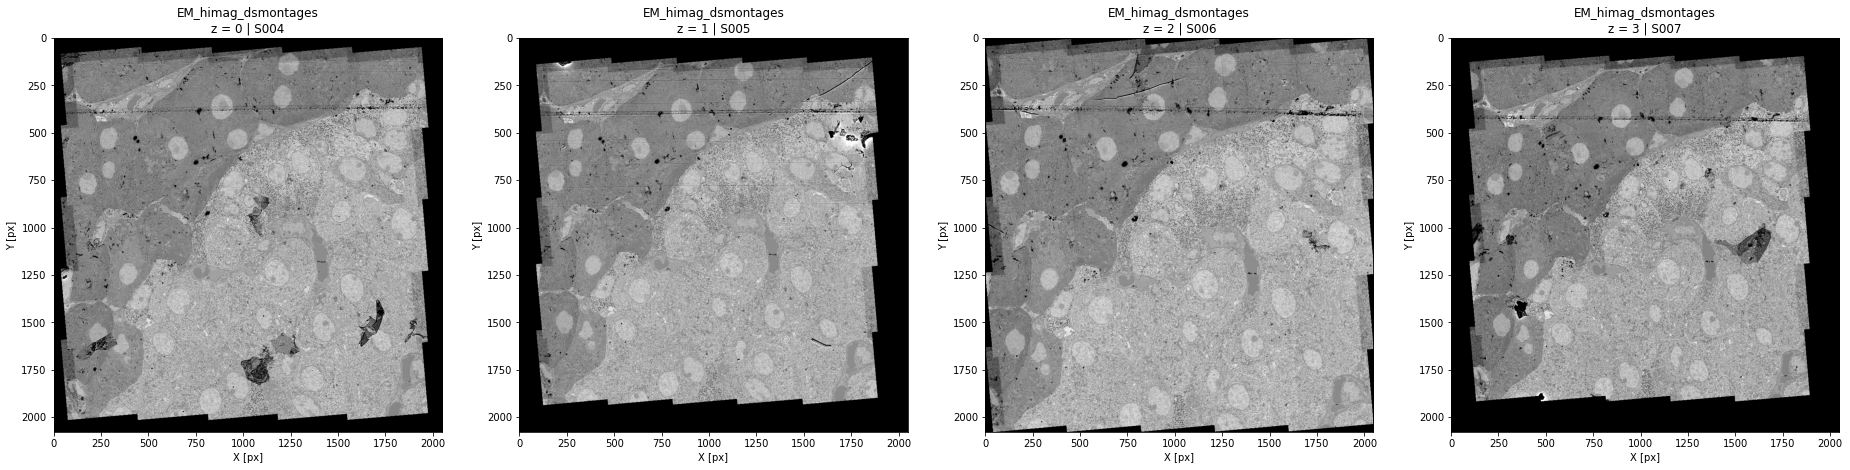

In [9]:
# Inspect dsmontage stack
stacks_2_plot = [stack_2_downsample['out']]
icatapi.plot_stacks(stacks=stacks_2_plot,
                    render=render)

## 3) Rough alignment (II)
---

### Align `dsmontage` stack

In [10]:
stack_2_align_ds = {
    'in': 'EM_himag_dsmontages',
    'out': 'EM_himag_dsmontages_aligned'
}

#### Collect tile pairs

Tile pairs for rough alignment are the neighboring downsampled montage images of each section. Collection of tile pairs is generated from a `render-python` client script. This client selects a set of tiles `p` based on its position in a stack and then searches for nearby `q` tiles using geometric parameters.

script | code
------ | ----
client script | [`renderapi.client.tilePairClient`](https://github.com/fcollman/render-python/blob/721ac8845e3067af6c81f3c67f2c0fa24fb1723c/renderapi/client/client_calls.py#L129)
java script | [`TilePairClient.java`](https://github.com/saalfeldlab/render/blob/master/render-ws-java-client/src/main/java/org/janelia/render/client/TilePairClient.java)

In [11]:
# Get z values
z_values = renderapi.stack.get_z_values_for_stack(stack=stack_2_align_ds['in'],
                                                  render=render)

# Get tile pairs
tile_pairs_json = renderapi.client.tilePairClient(stack=stack_2_align_ds['in'],
                                                  minz=min(z_values),
                                                  maxz=max(z_values),
                                                  zNeighborDistance=1,
                                                  render=render)

# Convert to DataFrame
df_pairs = pd.json_normalize(tile_pairs_json['neighborPairs'])
df_pairs['stack'] = stack_2_align_ds['in']

# Preview
out = f"{len(df_pairs)} tile pairs"
print(out + '\n' + '.'*len(out))
df_pairs.sample(min(5, len(df_pairs)))

3 tile pairs
............


,p.groupId,p.id,q.groupId,q.id,stack
2,S006,dsm-EM_himag_sti...,S007,dsm-EM_himag_sti...,EM_himag_dsmontages
0,S004,dsm-EM_himag_sti...,S005,dsm-EM_himag_sti...,EM_himag_dsmontages
1,S005,dsm-EM_himag_sti...,S006,dsm-EM_himag_sti...,EM_himag_dsmontages


#### Set `SIFT` & `RANSAC` parameters

In [12]:
from renderapi.client import (MatchDerivationParameters,
                              FeatureExtractionParameters,
                              SiftPointMatchOptions)

In [13]:
# `RANSAC` parameters
match_params = MatchDerivationParameters(matchIterations=None,
                                         matchMaxEpsilon=25,        # maximal alignment error
                                         matchMaxNumInliers=None,
                                         matchMaxTrust=None,
                                         matchMinInlierRatio=0.05,  # minimal inlier ratio
                                         matchMinNumInliers=7,      # minimal number of inliers
                                         matchModelType='AFFINE',   # expected transformation
                                         matchRod=0.92)             # closest/next closest ratio
# `SIFT` parameters
feature_params = FeatureExtractionParameters(SIFTfdSize=8,          # feature descriptor size
                                             SIFTmaxScale=0.20,     # (width/height *) maximum image size
                                             SIFTminScale=0.05,     # (width/height *) minimum image size
                                             SIFTsteps=7)           # steps per scale octave
# Combined `SIFT` & `RANSAC` parameters
sift_options = SiftPointMatchOptions(**{**match_params.__dict__,
                                        **feature_params.__dict__})
# Preview
list(sift_options.to_java_args())

['--SIFTfdSize',
 '8',
 '--SIFTmaxScale',
 '0.2',
 '--SIFTminScale',
 '0.05',
 '--SIFTsteps',
 '7',
 '--matchMaxEpsilon',
 '25',
 '--matchMinInlierRatio',
 '0.05',
 '--matchMinNumInliers',
 '7',
 '--matchModelType',
 'AFFINE',
 '--matchRod',
 '0.92']

#### Generate point matches

In [15]:
# Set match collection
match_collections = {
    stack_2_align_ds['in']: f"{project}_{stack_2_align_ds['in']}_points"
}
match_collections

{'EM_himag_dsmontages': 'ratpancreas_partial_EM_himag_dsmontages_points'}

In [16]:
# Set number of cores and batch size
N_cores = 1
batch_size = 2

# Generate point matches
icatapi.align.generate_point_matches(df_pairs,
                                     match_collections=match_collections,
                                     sift_options=sift_options,
                                     excludeAllTransforms=True,
                                     N_cores=N_cores,
                                     batch_size=batch_size,
                                     render=render)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

#### Collect point matches

In [17]:
# Set match collection
match_collection = match_collections[stack_2_align_ds['in']]

# Initialize DataFrame for collecting point matches
df_matches = pd.DataFrame()
# Loop through sections
for z in z_values:

    # Get sectionId from z value
    sectionId = renderapi.stack.get_sectionId_for_z(stack=stack_2_align_ds['in'],
                                                    z=z,
                                                    render=render)

    # Get point matches as json string
    matches_json = renderapi.pointmatch.get_matches_with_group(matchCollection=match_collection,
                                                               pgroup=sectionId,
                                                               render=render)

    # Convert to DataFrame
    df_matches = pd.concat([df_matches, pd.json_normalize(matches_json)])

# Merge with DataFrame of tile pairs to also get empty matches
df_matches['stack'] = stack_2_align_ds['in']
df_matches.reset_index(inplace=True, drop=True)
df_matches.rename(columns={'matchCount': 'N'}, inplace=True)
df_matches = pd.merge(
    df_matches,
    df_pairs.rename(columns={'p.groupId': 'pGroupId',
                             'q.groupId': 'qGroupId',
                             'p.id': 'pId',
                             'q.id': 'qId'}),
    how='outer',
    on=['stack', 'pGroupId', 'pId', 'qGroupId', 'qId'])

# Preview
out = f"""\
{len(df_matches.dropna())} / \
{len(df_matches)} \
({len(df_matches.dropna())/len(df_matches):.1%}) \
tile pair matches"""
print(out + '\n' + '.'*len(out))
df_matches.groupby('stack')\
          .apply(lambda x: x.sample(3))

3 / 3 (100.0%) tile pair matches
................................


pGroupId                  pId qGroupId  \
stack                                                          
EM_himag_dsmontages 2     S006  dsm-EM_himag_sti...     S007   
                    0     S004  dsm-EM_himag_sti...     S005   
                    1     S005  dsm-EM_himag_sti...     S006   

                                       qId   N            matches.p  \
stack                                                                 
EM_himag_dsmontages 2  dsm-EM_himag_sti...  65  [[552.2654761570...   
                    0  dsm-EM_himag_sti...  57  [[401.6082876632...   
                    1  dsm-EM_himag_sti...  61  [[194.7350630199...   

                                 matches.q            matches.w  \
stack                                                             
EM_himag_dsmontages 2  [[606.3539039232...  [1.0, 1.0, 1.0, ...   
                    0  [[404.5514837426...  [1.0, 1.0, 1.0, ...   
                    1  [[116.9744175968...  [1.0, 1.0, 1.0, ...   

                                     stack  
stack                                       
EM_himag_dsmontages 2  EM_himag_dsmontages  
                    0  EM_himag_dsmontages  
                    1  EM_himag_dsmontages

In [18]:
icatapi.plotting.plot_matches_across_sections(df_matches, width=100, height=100)

alt.FacetChart(...)

### Run `BigFeta` align

In [19]:
import os
import subprocess
import json
from pprint import pprint

#### Edit `align.json` template

In [59]:
# Load montage json template
template_align_json = Path('/home/rlane/iCAT-workflow/templates/align.json')
with template_align_json.open('r') as json_data:
    params_align_rough = json.load(json_data)

# Edit BigFeta solver schema
params_align_rough['first_section'] = min(z_values)
params_align_rough['last_section'] = max(z_values)
params_align_rough['solve_type'] = '3D'
params_align_rough['transformation'] = 'rigid'
params_align_rough['log_level'] = 'INFO'

# Edit input stack data
params_align_rough['input_stack']['owner'] = owner
params_align_rough['input_stack']['project'] = project
params_align_rough['input_stack']['name'] = stack_2_align_ds['in']

# Edit point match stack data
params_align_rough['pointmatch']['owner'] = owner
params_align_rough['pointmatch']['name'] = match_collection

# Edit output stack data
params_align_rough['output_stack']['owner'] = owner
params_align_rough['output_stack']['project'] = project
params_align_rough['output_stack']['name'] = stack_2_align_ds['out']

# Edit regularization parameters
params_align_rough['regularization']['default_lambda'] = 0.1      # default: 0.005
params_align_rough['regularization']['translation_factor'] = 0.1  # default: 0.005
params_align_rough['regularization']['thinplate_factor'] = 1e-5     # default: 1e-5

# Export montage settings to
align_json = dir_project / '_jsons_align_rough' / stack_2_align_ds['in'] / 'align_rough.json'
align_json.parent.mkdir(parents=True, exist_ok=True)
with align_json.open('w') as json_data:
    json.dump(params_align_rough, json_data, indent=2)

# Check alignment parameters
print(align_json)
print('...')
pprint(params_align_rough)

/long_term_storage/rlane/SECOM/projects/20191101_rat-pancreas_partial/_jsons_align_rough/EM_himag_dsmontages/align_rough.json
...
{'close_stack': 'True',
 'first_section': 0.0,
 'hdf5_options': {'chunks_per_file': -1, 'output_dir': ''},
 'input_stack': {'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
                 'collection_type': 'stack',
                 'db_interface': 'mongo',
                 'host': 'sonic.tnw.tudelft.nl',
                 'mongo_host': 'sonic.tnw.tudelft.nl',
                 'mongo_port': 27017,
                 'name': 'EM_himag_dsmontages',
                 'owner': 'rlane',
                 'port': 8080,
                 'project': 'ratpancreas_partial'},
 'last_section': 3.0,
 'log_level': 'INFO',
 'matrix_assembly': {'cross_pt_weight': 1.0,
                     'depth': 2,
                     'inverse_dz': 'True',
                     'montage_pt_weight': 1.0,
                     'npts_max': 500,
                    

#### Run `BigFeta`

In [60]:
# Path to `BigFeta`
cwd = Path.cwd().as_posix()
BigFeta_dir = Path('/home/catmaid/BigFeta/')

# Select json for rough alignment
align_json = dir_project / '_jsons_align_rough' / stack_2_align_ds['in'] / 'align_rough.json'

# Call `BigFeta.BigFeta` process -- have to switch to BigFeta directory
os.chdir(BigFeta_dir.as_posix())
subprocess.run(['python', '-m', 'bigfeta.bigfeta', '--input_json', align_json.as_posix()])
os.chdir(cwd)

#### Inspect alignment

  0%|          | 0/4 [00:00<?, ?it/s]

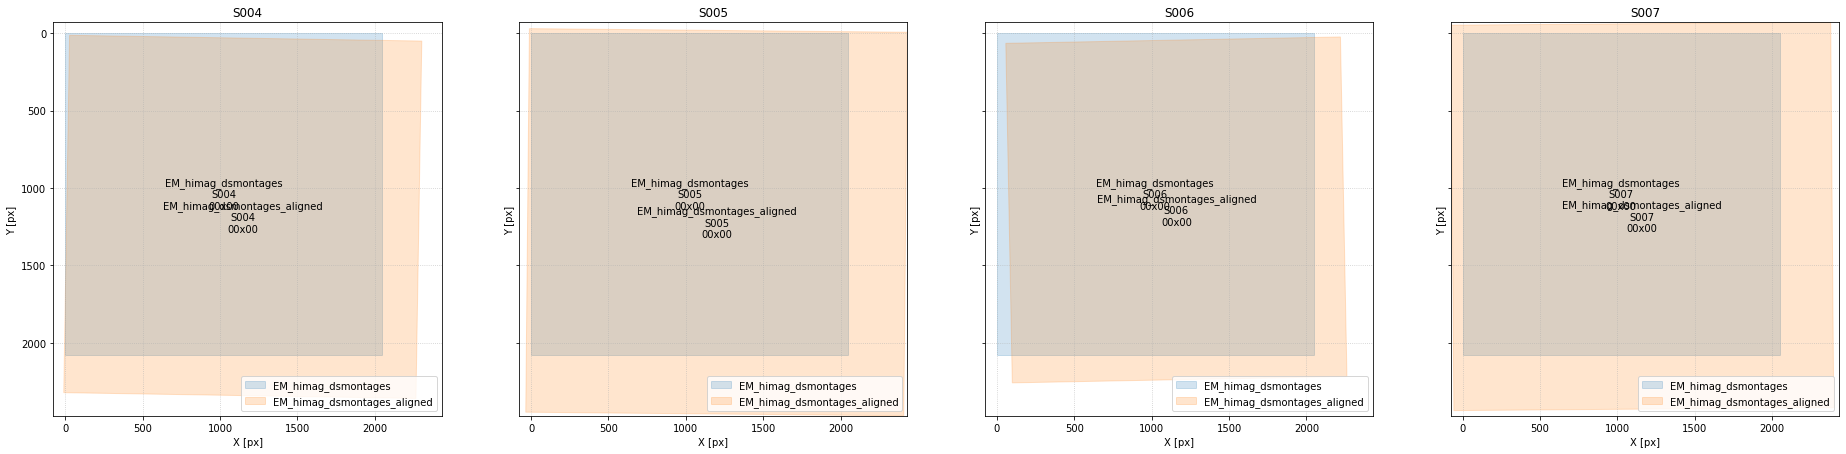

In [63]:
stacks_2_plot = stack_2_align_ds.values()
icatapi.plot_tile_map(stacks=stacks_2_plot,
                      render=render)

In [64]:
# Collect stack images
stack_images = {}
for stack in tqdm(stacks_2_plot):
    # {stack: {z: image}}
    stack_images[stack] = icatapi.render_stack_images(stack,
                                                      maxTileSpecsToRender=1000,
                                                      render=render)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [65]:
interact(icatapi.plot_stacks_interactive,
         z=IntSlider(min=min(z_values),
                     max=max(z_values)),
         stack_images=fixed(stack_images),
         render=fixed(render));

interactive(children=(IntSlider(value=0, description='z', max=3), Output()), _dom_classes=('widget-interact',)…

## 4) Rough alignmennt (III)
---

### Propagate transform to stitched together stack
The output stack is only used to generate tile pairs from. Doesn't really matter what the resulting stack looks like so much as long it's roughly aligned in `z` and not too crazy.

In [66]:
stack_2_align_rough = {
    'in': 'EM_himag_stitched',
    'out': 'EM_himag_aligned_rough'
}

In [70]:
# Load DataFrame of stack to roughly align
df_stack = icatapi.create_stack_DataFrame(stack=stack_2_align_rough['in'],
                                          render=render)

# Loop through sections
for z, df_tileset in tqdm(df_stack.groupby('z'),
                          total=len(z_values)):

    # Get the transformation from the aligned downsampled stack
    Ts = renderapi.tilespec.get_tile_specs_from_z(stack=stack_2_align_ds['out'],
                                                 z=z,
                                                 render=render)[0].tforms

    # Loop through tiles
    for i, tile in df_tileset.iterrows():

        # Append transform 
        df_stack.at[i, 'tforms'] += Ts

# Sneak peak
df_stack.sample(min(5, len(df_stack)))

  0%|          | 0/4 [00:00<?, ?it/s]

,tileId,z,width,height,minint,maxint,imagePyramid,tforms,stack,sectionId,imageRow,imageCol,stageX,stageY
9,aaj_EM_himag-S00...,0.0,4096.0,4096.0,31540.0,35118.0,"[0, 1, 2, 3, 4, ...","[M=[[0.351452,0....",EM_himag_stitched,S004,5,6,1079.298,6353.060
32,aah_EM_himag-S00...,1.0,4096.0,4096.0,31465.0,35198.0,"[0, 1, 2, 3, 4, ...","[M=[[0.326958,0....",EM_himag_stitched,S005,5,4,1641.361,6360.817
95,aau_EM_himag-S00...,3.0,4096.0,4096.0,31832.0,35051.0,"[0, 1, 2, 3, 4, ...","[M=[[0.326503,0....",EM_himag_stitched,S007,2,6,2874.165,6400.161
20,aau_EM_himag-S00...,0.0,4096.0,4096.0,31540.0,35118.0,"[0, 1, 2, 3, 4, ...","[M=[[0.352170,0....",EM_himag_stitched,S004,2,6,1078.481,6405.824
56,aag_EM_himag-S00...,2.0,4096.0,4096.0,31616.0,35080.0,"[0, 1, 2, 3, 4, ...","[M=[[0.371113,0....",EM_himag_stitched,S006,5,3,2233.121,6363.375


#### Upload stack

In [74]:
upload_stack_DataFrame(df_stack,
                       name=stack_2_align_rough['out'],
                       render=render)

Creating tile specifications for EM_himag_aligned_rough...
Importing tile specifications to EM_himag_aligned_rough...
Stack EM_himag_aligned_rough created successfully.


#### Inspect alignment

  0%|          | 0/4 [00:00<?, ?it/s]

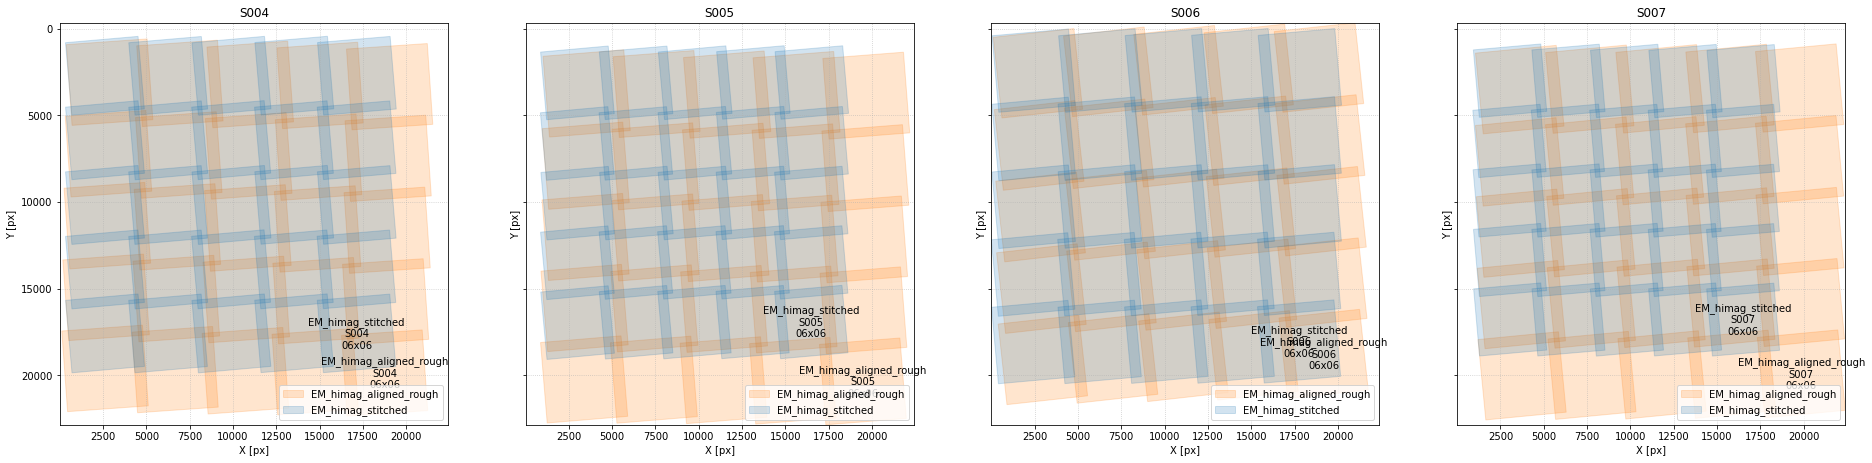

In [75]:
stacks_2_plot = stack_2_align_rough.values()
icatapi.plot_tile_map(stacks=stacks_2_plot,
                      render=render)

In [76]:
# Collect stack images
stack_images = {}
for stack in tqdm(stacks_2_plot):
    # {stack: {z: image}}
    stack_images[stack] = icatapi.render_stack_images(stack,
                                                      maxTileSpecsToRender=1000,
                                                      render=render)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [77]:
interact(icatapi.plot_stacks_interactive,
         z=IntSlider(min=min(z_values),
                     max=max(z_values)),
         stack_images=fixed(stack_images),
         render=fixed(render));

interactive(children=(IntSlider(value=0, description='z', max=3), Output()), _dom_classes=('widget-interact',)…

## 5) Fine alignment
---

In [78]:
stack_2_align_fine = {
    'in': 'EM_himag',
    'out': 'EM_himag_aligned_fine'
}

#### Collect tile pairs

Tile pairs for rough alignment are the neighboring downsampled montage images of each section. Collection of tile pairs is generated from a `render-python` client script. This client selects a set of tiles `p` based on its position in a stack and then searches for nearby `q` tiles using geometric parameters.

script | code
------ | ----
client script | [`renderapi.client.tilePairClient`](https://github.com/fcollman/render-python/blob/721ac8845e3067af6c81f3c67f2c0fa24fb1723c/renderapi/client/client_calls.py#L129)
java script | [`TilePairClient.java`](https://github.com/saalfeldlab/render/blob/master/render-ws-java-client/src/main/java/org/janelia/render/client/TilePairClient.java)

In [79]:
# Get z values
z_values = renderapi.stack.get_z_values_for_stack(stack=stack_2_align_rough['out'],
                                                  render=render)

# Get tile pairs
tile_pairs_json = renderapi.client.tilePairClient(stack=stack_2_align_rough['out'],
                                                  minz=min(z_values),
                                                  maxz=max(z_values),
                                                  zNeighborDistance=1,
                                                  xyNeighborFactor=0.1,
                                                  excludeSameLayerNeighbors=True,
                                                  render=render)

# Convert to DataFrame
df_pairs = pd.json_normalize(tile_pairs_json['neighborPairs'])
df_pairs['stack'] = stack_2_align_fine['in']

# Preview
out = f"{len(df_pairs)} tile pairs"
print(out + '\n' + '.'*len(out))
df_pairs.sample(min(7, len(df_pairs)))

103 tile pairs
..............


,p.groupId,p.id,q.groupId,q.id,stack
30,S005,aaf_EM_himag-S00...,S006,aae_EM_himag-S00...,EM_himag
54,S005,aar_EM_himag-S00...,S006,aam_EM_himag-S00...,EM_himag
49,S005,aao_EM_himag-S00...,S006,aao_EM_himag-S00...,EM_himag
61,S005,aau_EM_himag-S00...,S006,aau_EM_himag-S00...,EM_himag
85,S006,aak_EM_himag-S00...,S007,aat_EM_himag-S00...,EM_himag
26,S005,aab_EM_himag-S00...,S006,aab_EM_himag-S00...,EM_himag
43,S005,aal_EM_himag-S00...,S006,aal_EM_himag-S00...,EM_himag


#### Generate point matches

In [80]:
# Set match collection
match_collections = {
    stack_2_align_fine['in']: f"{project}_{stack_2_align_fine['in']}_points"
}
match_collections

{'EM_himag': 'ratpancreas_partial_EM_himag_points'}

In [85]:
# Check that point match collection exists
df_matches = icatapi.montage.get_matches_within_stack(stack=stack_2_align_fine['in'],
                                                      match_collection=match_collections[stack_2_align_fine['in']],
                                                      render=render)
icatapi.plot_matches_within_section(df_matches,
                                    direction='ew',
                                    width=150,
                                    height=150)

  0%|          | 0/4 [00:00<?, ?it/s]

alt.FacetChart(...)

In [82]:
# Set number of cores and batch size
N_cores = 25
batch_size = 12

# Generate point matches
icatapi.align.generate_point_matches(df_pairs,
                                     match_collections=match_collections,
                                     sift_options=sift_options,
                                     excludeAllTransforms=True,
                                     N_cores=N_cores,
                                     batch_size=batch_size,
                                     render=render)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

#### Collect point matches

In [83]:
# Set match collection
match_collection = match_collections[stack_2_align_fine['in']]

# Initialize DataFrame for collecting point matches
df_matches = pd.DataFrame()
# Loop through sections
for z in z_values:

    # Get sectionId from z value
    sectionId = renderapi.stack.get_sectionId_for_z(stack=stack_2_align_fine['in'],
                                                    z=z,
                                                    render=render)

    # Get point matches as json string
    matches_json = renderapi.pointmatch.get_matches_with_group(matchCollection=match_collection,
                                                               pgroup=sectionId,
                                                               render=render)

    # Convert to DataFrame
    df_matches = pd.concat([df_matches, pd.json_normalize(matches_json)])

# Add row/col indices
df_matches[['pc', 'pr']] = np.stack(df_matches['pId'].apply(lambda x:\
                                    [int(i) for i in re.findall(r'\d+', x)[-2:]]))
df_matches[['qc', 'qr']] = np.stack(df_matches['qId'].apply(lambda x:\
                                    [int(i) for i in re.findall(r'\d+', x)[-2:]]))

# Merge with DataFrame of tile pairs to also get empty matches
df_matches['stack'] = stack_2_align_fine['in']
df_matches.reset_index(inplace=True, drop=True)
df_matches.rename(columns={'matchCount': 'N'}, inplace=True)
df_matches = pd.merge(
    df_matches,
    df_pairs.rename(columns={'p.groupId': 'pGroupId',
                             'q.groupId': 'qGroupId',
                             'p.id': 'pId',
                             'q.id': 'qId'}),
    how='outer',
    on=['stack', 'pGroupId', 'pId', 'qGroupId', 'qId'])

# Preview
out = f"""\
{len(df_matches.dropna())} / \
{len(df_matches)} \
({len(df_matches.dropna())/len(df_matches):.1%}) \
tile pair matches"""
print(out + '\n' + '.'*len(out))
df_matches.groupby('stack')\
          .apply(lambda x: x.sample(3))

228 / 263 (86.7%) tile pair matches
...................................


pGroupId                  pId qGroupId                  qId  \
stack                                                                      
EM_himag 248     S005  aau_EM_himag-S00...     S006  aat_EM_himag-S00...   
         109     S005  aai_EM_himag-S00...     S006  aai_EM_himag-S00...   
         140     S006  aai_EM_himag-S00...     S006  aal_EM_himag-S00...   

                  N            matches.p            matches.q  \
stack                                                           
EM_himag 248    NaN                  NaN                  NaN   
         109   10.0  [[921.1942650134...  [[685.9132259732...   
         140  128.0  [[3563.661346265...  [[3230.060696601...   

                        matches.w   pc   pr   qc   qr     stack  
stack                                                            
EM_himag 248                  NaN  NaN  NaN  NaN  NaN  EM_himag  
         109  [1.0, 1.0, 1.0, ...  5.0  5.0  5.0  5.0  EM_himag  
         140  [1.0, 1.0, 1.0, ...  5.0  5.0  5.0  4.0  EM_himag

In [84]:
icatapi.plotting.plot_matches_across_sections(df_matches, width=240, height=240)

alt.FacetChart(...)

### Run `BigFeta` align

#### Edit `align.json` template

In [91]:
# Load montage json template
template_align_json = Path('/home/rlane/iCAT-workflow/templates/align.json')
with template_align_json.open('r') as json_data:
    params_align_fine = json.load(json_data)

# Edit BigFeta solver schema
params_align_fine['first_section'] = min(z_values)
params_align_fine['last_section'] = max(z_values)
params_align_fine['solve_type'] = '3D'
params_align_fine['transformation'] = 'affine'
params_align_fine['log_level'] = 'INFO'

# Edit input stack data
params_align_fine['input_stack']['owner'] = owner
params_align_fine['input_stack']['project'] = project
params_align_fine['input_stack']['name'] = stack_2_align_fine['in']

# Edit point match stack data
params_align_fine['pointmatch']['owner'] = owner
params_align_fine['pointmatch']['name'] = match_collection

# Edit output stack data
params_align_fine['output_stack']['owner'] = owner
params_align_fine['output_stack']['project'] = project
params_align_fine['output_stack']['name'] = stack_2_align_fine['out']

# Edit regularization parameters
params_align_fine['regularization']['default_lambda'] = 1e-2       # default: 0.005
params_align_fine['regularization']['translation_factor'] = 1e-2   # default: 0.005
params_align_fine['regularization']['thinplate_factor'] = 1e-5     # default: 1e-5

# Export montage settings to
align_json = dir_project / '_jsons_align_fine' / stack_2_align_fine['in'] / 'align_fine.json'
align_json.parent.mkdir(parents=True, exist_ok=True)
with align_json.open('w') as json_data:
    json.dump(params_align_fine, json_data, indent=2)

# Check alignment parameters
print(align_json)
print('...')
pprint(params_align_fine)

/long_term_storage/rlane/SECOM/projects/20191101_rat-pancreas_partial/_jsons_align_fine/EM_himag/align_fine.json
...
{'close_stack': 'True',
 'first_section': 0.0,
 'hdf5_options': {'chunks_per_file': -1, 'output_dir': ''},
 'input_stack': {'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
                 'collection_type': 'stack',
                 'db_interface': 'mongo',
                 'host': 'sonic.tnw.tudelft.nl',
                 'mongo_host': 'sonic.tnw.tudelft.nl',
                 'mongo_port': 27017,
                 'name': 'EM_himag',
                 'owner': 'rlane',
                 'port': 8080,
                 'project': 'ratpancreas_partial'},
 'last_section': 3.0,
 'log_level': 'INFO',
 'matrix_assembly': {'cross_pt_weight': 1.0,
                     'depth': 2,
                     'inverse_dz': 'True',
                     'montage_pt_weight': 1.0,
                     'npts_max': 500,
                     'npts_min': 5},
 'outpu

#### Run `BigFeta`

In [92]:
# Path to `BigFeta`
cwd = Path.cwd().as_posix()
BigFeta_dir = Path('/home/catmaid/BigFeta/')

# Select json for fine alignment
align_json = dir_project / '_jsons_align_fine' / stack_2_align_fine['in'] / 'align_fine.json'

# Call `BigFeta.BigFeta` process -- have to switch to BigFeta directory
os.chdir(BigFeta_dir.as_posix())
subprocess.run(['python', '-m', 'bigfeta.bigfeta', '--input_json', align_json.as_posix()])
os.chdir(cwd)

#### Inspect alignment

  0%|          | 0/4 [00:00<?, ?it/s]

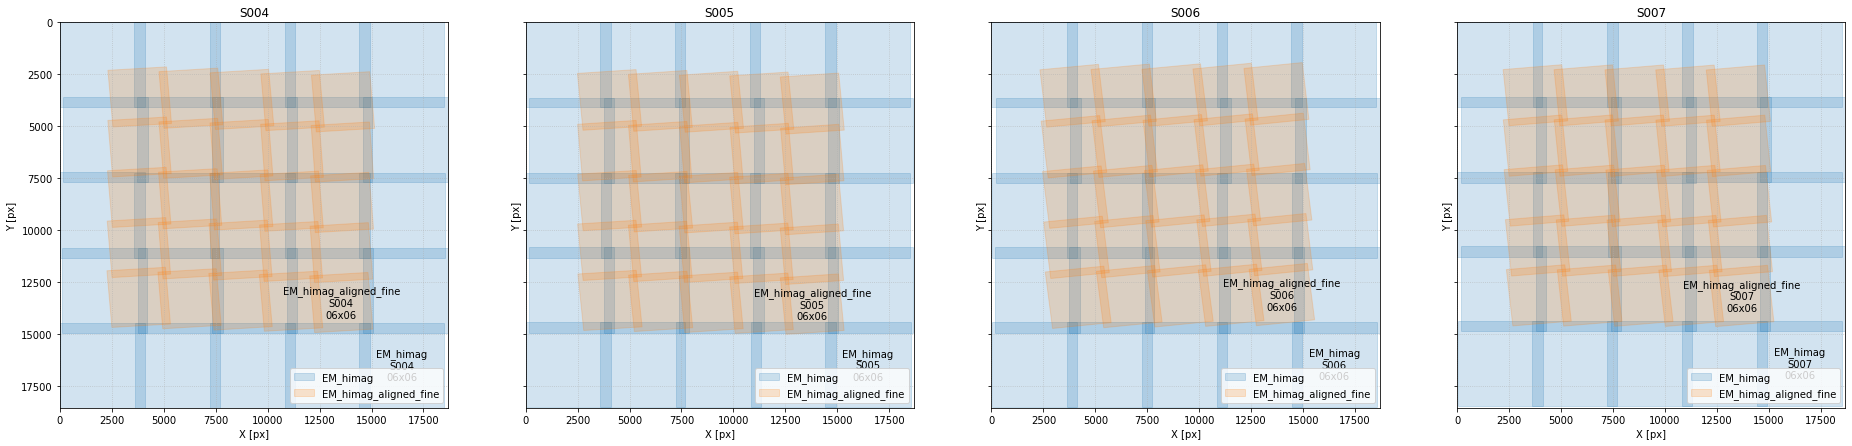

In [93]:
stacks_2_plot = stack_2_align_fine.values()
icatapi.plot_tile_map(stacks=stacks_2_plot,
                      render=render)

In [94]:
# Collect stack images
stack_images = {}
for stack in tqdm(stacks_2_plot):
    # {stack: {z: image}}
    stack_images[stack] = icatapi.render_stack_images(stack,
                                                      maxTileSpecsToRender=1000,
                                                      render=render)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [95]:
interact(icatapi.plot_stacks_interactive,
         z=IntSlider(min=min(z_values),
                     max=max(z_values)),
         stack_images=fixed(stack_images),
         render=fixed(render));

interactive(children=(IntSlider(value=0, description='z', max=3), Output()), _dom_classes=('widget-interact',)…

## Scale aligned stack
---

In [96]:
from matplotlib.transforms import Affine2D as AffineMPL
from renderapi.transform import AffineModel as AffineRender

from icatapi.render_pandas import create_stack_DataFrame, upload_stack_DataFrame
from icatapi.render_transforms import scale_stack

#### Determine scaling factor
Scale each tileset by the same factor. So determine the average scale and multiply by that

In [100]:
stack_2_scale = {
    'in': stack_2_align_fine['out'],
    'out': 'EM_himag_aligned'
}

In [101]:
# Collect scaling factors
scales_x = []
scales_y = []

# Create stack DataFrame
df_stack = create_stack_DataFrame(stack=stack_2_scale['in'],
                                  render=render)

# Loop through sections
for z, layer in tqdm(df_stack.groupby('z'),
                     total=len(df_stack['z'].unique())):

    # Get transform data
    columns = ['M00', 'M10', 'M01', 'M11', 'B0', 'B1']
    tforms = pd.DataFrame(layer['tforms']\
               .apply(lambda x: x[0].dataString)\
               .str.split(' ', expand=True).values, columns=columns)\
               .astype(float)

    # Extract scale from affine transform
    M = AffineMPL(np.array([[tforms['M00'].mean(), tforms['M01'].mean(), 0],
                            [tforms['M10'].mean(), tforms['M11'].mean(), 0],
                            [                   0,                    0, 1]]))
    R, S = np.linalg.qr(M.get_matrix())
    mask = np.diag(S) < 0.
    S[mask, :] *= -1.
    # Set scale
    sx = 1/S[0,0]
    sy = 1/S[1,1]

    # Collect scaling factors
    scales_x.append(sx)
    scales_y.append(sy)

# Put into arrays
scales_x = np.array(scales_x)
scales_y = np.array(scales_y)
# Find average
sx = scales_x.mean()
sy = scales_y.mean()

# Out
sx, sy

  0%|          | 0/4 [00:00<?, ?it/s]

(1.4528189823736999, 1.4972469712203327)

#### Scale stack

In [103]:
# Scale stack
scale_stack(stack_in=stack_2_scale['in'],
            stack_out=stack_2_scale['out'],
            sx=sx,
            sy=sy,
            translate=True,
            render=render)

Creating tile specifications for EM_himag_aligned...
Importing tile specifications to EM_himag_aligned...
Stack EM_himag_aligned created successfully.


#### Plot tiles

  0%|          | 0/4 [00:00<?, ?it/s]

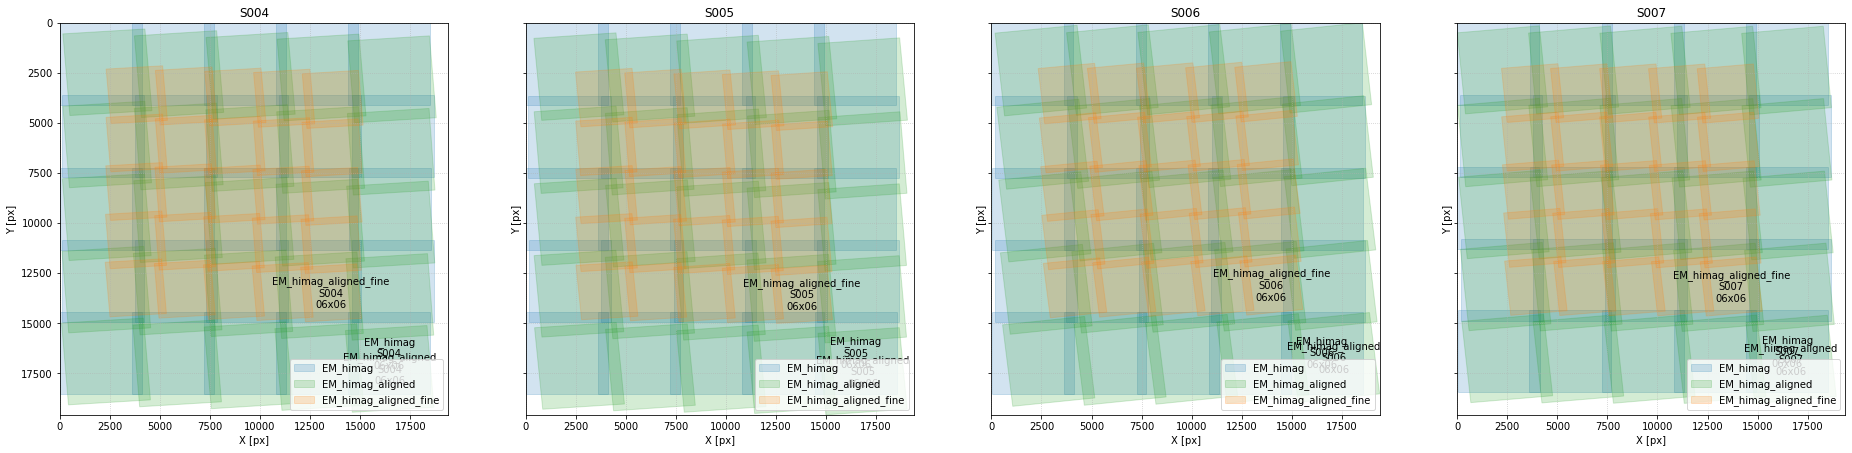

In [108]:
stacks_2_plot = [stack_2_align_fine['in']] + list(stack_2_scale.values())

icatapi.plotting.plot_tile_map(stacks=stacks_2_plot,
                               render=render)